# Last scan: all AR durations and AR=1.3 tracks

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

In [7]:
stat_path = Path("../stat")

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [9]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info

In [10]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [11]:
df_summary["TRIAL_TO_INCLUDE"] = df_main["TRIAL_TO_INCLUDE"]

In [12]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

## Spheroid names and colors

In [13]:
SPH_COLORS = ["w", "gainsboro", "darkgrey"]  # L, M, S

In [14]:
SPH_STR = ["L", "M", "S"]
SPH_LABEL = ["2.9", "1.3", "1.1"] # ["AR=2.9", "AR=1.3", "AR=1.1"]

In [15]:
sph_tcct = [f"{sph}_{tcct_type}" for sph, tcct_type in zip(["L", "M", "S"]*2, ["TC"]*3+["CT"]*3)]

In [16]:
sph_tcct

['L_TC', 'M_TC', 'S_TC', 'L_CT', 'M_CT', 'S_CT']

## Sort clusters

### 7clusters

In [17]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [18]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [19]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [20]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [21]:
CLUSTER_STR_7 = ["Straight", "Curved-1", "Curved-2", "Straight", "Curved-1", "Curved-2"]

## Track during last scan

In [22]:
def get_last_scan_track(trial_idx):
    
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
       
    # Get track and track portion
    df_track = tp.df_track
    df_track_last_scan = df_track[
        (df_track["time_corrected"] > tp.last_scan_start)
        & (df_track["time_corrected"] < tp.last_scan_end)
    ].copy()

    return df_track, df_track_last_scan

In [23]:
# Gather all tracks
df_track_all = []
df_track_ls_all = []

for c_seq, df_c in enumerate(df_cluster_clean_7):  # loop through all clusters
    
    print(f"Extracting tracks from cluster {c_seq}")
    print(f"Number of tracks: {len(df_c)}")
    
    # Loop through all trials
    df_track_tmp = []
    df_track_ls_tmp = []
    for trial_idx in df_c.index:
        df_track, df_track_ls = get_last_scan_track(trial_idx)

        df_track_tmp.append(df_track)
        df_track_ls_tmp.append(df_track_ls)
    
    df_track_all.append(df_track_tmp)
    df_track_ls_all.append(df_track_ls_tmp)

Extracting tracks from cluster 0
Number of tracks: 16
Extracting tracks from cluster 1
Number of tracks: 16
Extracting tracks from cluster 2
Number of tracks: 9
Extracting tracks from cluster 3
Number of tracks: 23
Extracting tracks from cluster 4
Number of tracks: 8
Extracting tracks from cluster 5
Number of tracks: 6


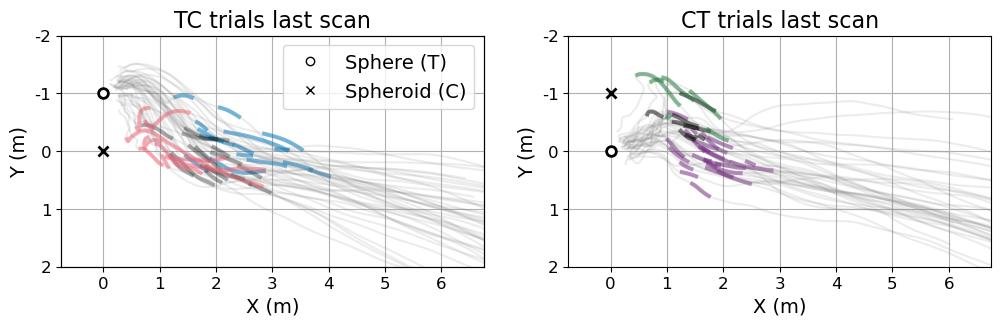

In [24]:
fig, ax_all = plt.subplots(1, 2, figsize=(12, 3), facecolor="w")

plt.subplots_adjust(hspace=0.4)



# ======================================
# TC trials last scan trajectories
# ======================================
ax_track_TC = ax_all[0]

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[:3], list(color_cluster_7.keys())[:3], list(color_cluster_7.values())[:3]
):
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_TC.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.3
            )
        else:
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.5
            )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=2, markersize=7, lw=1.5)
ax_track_TC.plot(0, -1, "ko", markeredgewidth=2, markersize=7, lw=1.5, markerfacecolor="w")
ax_track_TC.set_title("TC trials last scan", fontsize=16)


# ======================================
# CT trials last scan trajectories
# ======================================
ax_track_CT = ax_all[1]

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[3:], list(color_cluster_7.keys())[3:], list(color_cluster_7.values())[3:]
):    
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_CT.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.3
            )
        else:
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.5
            )
ax_track_CT.plot(0, -1, "kx", markeredgewidth=2, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=2, markersize=7, markerfacecolor="w")
ax_track_CT.set_title("CT trials last scan", fontsize=16)


# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (T)", markerfacecolor="w")
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (C)")
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=14, loc="upper right")


# Adjust xy-limit of trajetory panels
for axx in [ax_track_TC, ax_track_CT]:
    axx.set_xticks(np.arange(-1, 9))
    axx.set_xticklabels(np.arange(-1, 9), fontsize=12)
    axx.set_yticks(np.arange(-3, 4))
    axx.set_yticklabels(np.arange(-3, 4), fontsize=12)
    axx.set_ylim(2, -2)
    axx.set_xlim(-0.75, 6.75)
    axx.grid()
    axx.set_xlabel("X (m)", fontsize=14)
    axx.set_ylabel("Y (m)", fontsize=14)

## Functions to annotate p values

In [25]:
def add_TCCT_text(ax):
    ylim = ax.get_ylim()
    ax.text(1, ylim[1]*1.03, "TC", fontsize=12, ha="center", fontweight="bold")
    ax.text(4, ylim[1]*1.03, "CT", fontsize=12, ha="center", fontweight="bold")

In [26]:
def annotate_p_val_position(ax, df_stat):
    p_val_position = utils_plot.get_p_val_position(df_stat)
    ax.annotate('', xy=(0.32, 1.03), xycoords='axes fraction', xytext=(0.68, 1.02),
        arrowprops=dict(arrowstyle="-", color='k', lw=1.2))
    ylim = ax.get_ylim()
    ax.text(
        2.5, ylim[1]*1.03, f"{p_val_position:2.2E}",
        ha="center", va="bottom", fontsize=9
    )

In [27]:
def annotate_p_val_spheroid(ax, df_stat, ratio=False, vert_h=np.array([0.9 , 0.8, 0.7, 0.9 , 0.8, 0.7])):
    # Get p values
    constrast_str = utils_plot.STAT_CONTRAST_RATIO_AR if ratio else utils_plot.STAT_CONTRAST_DIFF_AR
    p_val_spheroid = [
        utils_plot.get_p_val_group(
            df_stat, utils_plot.STAT_POSITION[idx], constrast_str[idx]
        )
        for idx in np.arange(6)
    ]
    
    # Scale vertical position
    ylim = ax.get_ylim()
    vert_h = vert_h * (ylim[1] - ylim[0]) + ylim[0]

    # Annotate
    for idx in np.arange(6):
        ax.plot(utils_plot.STAT_PLOT_XPOS[idx], vert_h[idx] * np.ones(2), color="k")#, marker=".")
        ax.text(
            np.mean(utils_plot.STAT_PLOT_XPOS[idx]), vert_h[idx], f"{p_val_spheroid[idx]:2.2E}",
            ha="center", va="bottom", fontsize=8
        )

In [28]:
def annotate_p_val_cluster(ax, df_stat, ratio=False, vert_h=np.array([0.9 , 0.8, 0.7, 0.9 , 0.8, 0.7])):
    # Get p values
    constrast_str = utils_plot.STAT_CONTRAST_RATIO if ratio else utils_plot.STAT_CONTRAST_DIFF
    p_val_cluster = [
        utils_plot.get_p_val_group(
            df_stat, utils_plot.STAT_POSITION[idx], constrast_str[idx]
        )
        for idx in np.arange(6)
    ]
    
    # Scale vertical position
    ylim = ax.get_ylim()
    vert_h = vert_h * (ylim[1] - ylim[0]) + ylim[0]

    # Annotate
    for idx in np.arange(6):
        ax.plot(utils_plot.STAT_PLOT_XPOS[idx], vert_h[idx] * np.ones(2), color="k")#, marker=".")
        ax.text(
            np.mean(utils_plot.STAT_PLOT_XPOS[idx]), vert_h[idx], f"{p_val_cluster[idx]:2.2E}",
            ha="center", va="bottom", fontsize=8
        )

## Put panels together

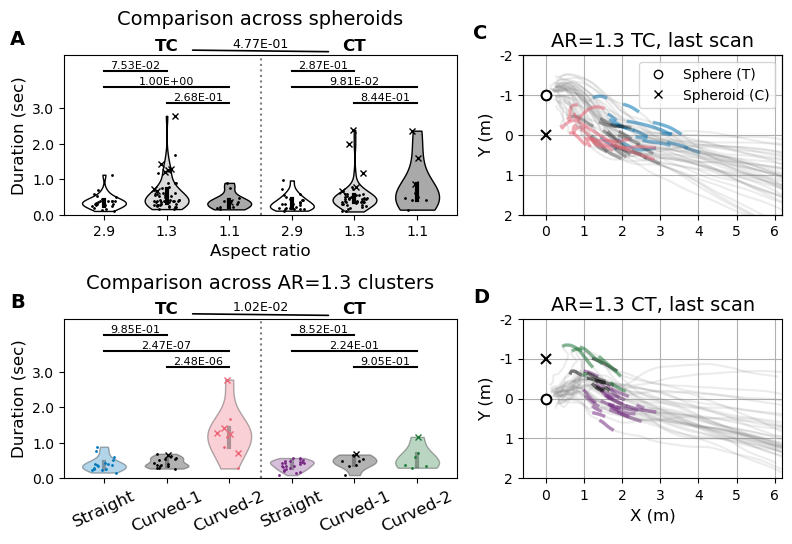

In [29]:
fig = plt.figure(figsize=(8.5, 5.5), facecolor="w")

gs = fig.add_gridspec(2, 5)

plt.subplots_adjust(hspace=0.65, wspace=0.05)


# ============================================
# Duration of last scan: spheroid comparison
# ============================================
ax_allAR = fig.add_subplot(gs[0, :3])

# TC/CT separate
for sph_seq, sph in enumerate(["L", "M", "S"]):
    for tcct_type in ["TC", "CT"]:

        sph_index = (
            (df_summary["SPHEROID"] == sph)
            & (df_summary["CHOICE"] == 1)
            & (df_summary["TRIAL_TO_INCLUDE"] == "Y")
            & (df_summary["TCCT"] == tcct_type)
        )
        df_wanted = df_summary[sph_index].copy()

        # trials with buzz before decision
        idx_cross = df_wanted["time_buzz_onset_clean"] < df_wanted["time_decision"]

        vals_dot = df_wanted["time_last_nonchosen"][~idx_cross].values
        vals_cross = df_wanted["time_last_nonchosen"][idx_cross].values

        vals = np.hstack((vals_dot, vals_cross))
        vals = vals[~np.isnan(vals)]
        
        sph_seq_plot = sph_seq if tcct_type=="TC" else sph_seq+3

        utils_plot.plot_vio(
            ax_allAR, vals, sph_seq_plot, widths=0.7,
            color=SPH_COLORS[sph_seq], qbar_alpha=1, alpha=1
        )
        utils_plot.plot_jitter(
            ax_allAR, sph_seq_plot, vals_dot, width=0.4,
            color="k", marker=".", markersize=2
        )
        utils_plot.plot_jitter(
            ax_allAR, sph_seq_plot, vals_cross, width=0.4,
            color="k", marker="x", markersize=4
        )
ax_allAR.set_title("Comparison across spheroids\n", fontsize=14)
ax_allAR.set_ylabel("Duration (sec)", fontsize=12)
ax_allAR.set_xticks(np.arange(6))
ax_allAR.set_xticklabels(SPH_LABEL * 2, fontsize=10)
ax_allAR.set_xlabel("Aspect ratio", fontsize=12)
ax_allAR.set_yticks(np.arange(0, 3.5, 1))
ax_allAR.set_yticklabels(np.arange(0, 3.5, 1), fontsize=10)
ax_allAR.set_ylim(0, 4.5)

# p value annotation
df_stat_position = pd.read_csv(stat_path / "ARall_last_scan_duration_position_contrast.csv")
df_stat_spheroid = pd.read_csv(stat_path / "ARall_last_scan_duration_spheroid_contrast.csv")
annotate_p_val_position(ax_allAR, df_stat_position)
annotate_p_val_spheroid(ax_allAR, df_stat_spheroid, ratio=True)
add_TCCT_text(ax_allAR)



# ==================================================
# Duration of last scan: AR=1.3 cluster comparison
# ==================================================
ax_AR13 = fig.add_subplot(gs[1, :3])

for seq in range(6):
    vals = df_cluster_clean_7[seq]["time_last_nonchosen"].values
    
    idx_cross = (
        df_cluster_clean_7[seq]["time_buzz_onset_clean"]
        < df_cluster_clean_7[seq]["time_decision"]
    )
    vals_dot = df_cluster_clean_7[seq]["time_last_nonchosen"][~idx_cross].values
    vals_cross = df_cluster_clean_7[seq]["time_last_nonchosen"][idx_cross].values
    
    utils_plot.plot_vio(
        ax_AR13, vals, seq,
        widths=0.7, color=color_cluster_seq_7[seq], qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        ax_AR13, seq, vals_dot, width=0.4,
        color=color_cluster_seq_7[seq], marker=".", markersize=2
    )
    utils_plot.plot_jitter(
        ax_AR13, seq, vals_cross, width=0.4,
        color=color_cluster_seq_7[seq], marker="x", markersize=4
    )
ax_AR13.set_title("Comparison across AR=1.3 clusters\n", fontsize=14)
ax_AR13.set_ylabel("Duration (sec)", fontsize=12)
ax_AR13.set_xticks(np.arange(6))
ax_AR13.set_xticklabels(CLUSTER_STR_7, fontsize=12, rotation=25)
ax_AR13.set_yticks(np.arange(0, 3.5, 1))
ax_AR13.set_yticklabels(np.arange(0, 3.5, 1), fontsize=10)
ax_AR13.set_ylim(0, 4.5)


# p value annotation
df_stat_position = pd.read_csv(stat_path / "AR13_last_scan_duration_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / "AR13_last_scan_duration_cluster_contrast.csv")
annotate_p_val_position(ax_AR13, df_stat_position)
annotate_p_val_cluster(ax_AR13, df_stat_cluster, ratio=True)
add_TCCT_text(ax_AR13)



# Add dotted line
for axx in [ax_allAR, ax_AR13]:
    axx.axvline(2.5, color="grey", ls=":")


# Move axes to left
for axx in [ax_AR13, ax_allAR]:
    axx_pos = axx.get_position()
    axx.set_position([axx_pos.x0-0.07, axx_pos.y0, axx_pos.width, axx_pos.height])



# ===========================
# Last scan TC tracks
# ===========================
ax_track_TC = fig.add_subplot(gs[0, 3:])

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[:3], list(color_cluster_7.keys())[:3], list(color_cluster_7.values())[:3]
):
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_TC.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=2.5, alpha=0.3
            )
        else:
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=2.5, alpha=0.5
            )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=1.5, markersize=7, lw=1.5)
ax_track_TC.plot(0, -1, "ko", markeredgewidth=1.5, markersize=7, lw=1.5, markerfacecolor="w")
ax_track_TC.set_title("AR=1.3 TC, last scan", fontsize=14)

# ===========================
# Last scan CT tracks
# ===========================
ax_track_CT = fig.add_subplot(gs[1, 3:])

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[3:], list(color_cluster_7.keys())[3:], list(color_cluster_7.values())[3:]
):    
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_CT.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=2.5, alpha=0.3
            )
        else:
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=2.5, alpha=0.5
            )
ax_track_CT.plot(0, -1, "kx", markeredgewidth=1.5, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=1.5, markersize=7, markerfacecolor="w")
ax_track_CT.set_title("AR=1.3 CT, last scan", fontsize=14)


# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (T)", markerfacecolor="w")
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (C)")
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=10, loc="upper right")


# Adjust xy-limit of trajetory panels
for axx in [ax_track_TC, ax_track_CT]:
    axx.set_xticks(np.arange(-1, 9))
#     axx.set_xticklabels("")
    axx.set_yticks(np.arange(-3, 4))
    axx.set_yticklabels(np.arange(-3, 4), fontsize=10)
    axx.set_ylim(2, -2)
#     axx.set_xlim(-0.75, 6.75)
    axx.set_xlim(-0.6, 6.2)
    axx.grid()
    axx.set_ylabel("Y (m)", fontsize=12)
ax_track_CT.set_xlabel("X (m)", fontsize=12)
ax_track_CT.set_xticklabels(np.arange(-1, 9), fontsize=10)



# Add panel labels
ax_allAR.text(-1.5, 4.8, "A", fontsize=14, fontweight="bold")
ax_AR13.text(-1.5, 4.8, "B", fontsize=14, fontweight="bold")
ax_track_TC.text(-1.9, -2.4, "C", fontsize=14, fontweight="bold")
ax_track_CT.text(-1.9, -2.4, "D", fontsize=14, fontweight="bold")



plt.show()

fig.savefig(fig_path / "fig_last_scan.png", dpi=300, bbox_inches="tight")


## Duration of buzz during last scan for M clusters

This is only for cases in which the buzz onset occurred before decision time.

In [30]:
buzz_duration_last_scan_pooled = []

for seq in range(6):
    print(list(color_cluster_7.keys())[seq])
    df_seq = df_cluster_clean_7[seq].copy()
    df_seq["buzz_duration_last_scan"] = df_seq["time_decision"] - df_seq["time_buzz_onset_clean"]
    val = df_seq["buzz_duration_last_scan"].values
    if sum(val[val>0]) > 0:
        print(df_seq["buzz_duration_last_scan"][val>0])
        buzz_duration_last_scan_pooled = buzz_duration_last_scan_pooled + list(val[val>0])

buzz_duration_last_scan_pooled = np.array(buzz_duration_last_scan_pooled)

TC_straight
TC_curved1
188    0.504673
Name: buzz_duration_last_scan, dtype: float64
TC_curved2
78     1.121533
92     0.581870
129    1.222482
161    0.599925
239    0.379210
Name: buzz_duration_last_scan, dtype: float64
CT_straight
CT_curved1
219    0.423846
Name: buzz_duration_last_scan, dtype: float64
CT_curved2
182    1.054794
Name: buzz_duration_last_scan, dtype: float64


In [31]:
buzz_duration_last_scan_pooled

array([0.5046734 , 1.1215335 , 0.58187   , 1.222482  , 0.5999252 ,
       0.37921   , 0.42384612, 1.054794  ])

In [32]:
print(f"Mean duration of buzz during last scan: {buzz_duration_last_scan_pooled.mean():2.2f} sec")

Mean duration of buzz during last scan: 0.74 sec


In [33]:
print(f"Max duration of buzz during last scan: {buzz_duration_last_scan_pooled.max():2.2f} sec")

Max duration of buzz during last scan: 1.22 sec
